# Analyzing a YouTube video speech

In [1]:
import azure.cognitiveservices.speech as speechsdk
import datetime
import csv
import json
import librosa
import matplotlib.pyplot as plt
import openai
import os
import requests
import sys
import time
import wave

from dotenv import load_dotenv
from pprint import pprint
from pydub import AudioSegment
from pytube import YouTube

In [2]:
sys.version

'3.10.10 (main, Mar 21 2023, 18:45:11) [GCC 11.2.0]'

In [3]:
print('Today is:', datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S'))

Today is: 21-Sep-2023 08:26:41


In [4]:
load_dotenv("azure.env")

# Azure Open AI
openai.api_type: str = "azure"
openai.api_key = os.getenv("OPENAI_API_KEY")
openai.api_base = os.getenv("OPENAI_API_BASE")
openai.api_version = os.getenv("OPENAI_API_VERSION")

azure_speech_key = os.getenv("AZURE_SPEECH_KEY")
azure_service_region = os.getenv("AZURE_SPEECH_REGION")

print("Open AI version:", openai.__version__)

Open AI version: 0.28.0


In [5]:
model = "text-davinci-003"

### YouTube video

In [6]:
youtube_video_url = "https://www.youtube.com/watch?v=DaIYrlMOj7I"

### Downloading the video

In [7]:
yt = YouTube(youtube_video_url)

audio = yt.streams.filter(only_audio=True).first()
download_file = audio.download()

In [8]:
audio

<Stream: itag="139" mime_type="audio/mp4" abr="48kbps" acodec="mp4a.40.5" progressive="False" type="audio">

In [9]:
!ls *.mp4 -lh

-rwxrwxrwx 1 root root 463K Sep 21 08:26 'Azure AI Studio Satya Nadella at Microsoft Build 2023.mp4'
-rwxrwxrwx 1 root root 463K Sep 20 14:46  audio.mp4


In [10]:
audio_file = "audio.mp4"

In [11]:
os.rename("Azure AI Studio Satya Nadella at Microsoft Build 2023.mp4", audio_file)

### Saving the audio mp4 file into wav

In [12]:
wavfile = "audio.wav"

# Load the MP4 audio as an AudioSegment
audio = AudioSegment.from_file(audio_file, format="mp4")

# Export the audio as a WAV file
audio.export(wavfile, format="wav")

<_io.BufferedRandom name='audio.wav'>

In [13]:
!ls $wavfile -lh

-rwxrwxrwx 1 root root 14M Sep 21 08:26 audio.wav


In [14]:
with wave.open(wavfile, "rb") as wav_file:
    # Get the number of channels (1 for mono, 2 for stereo, etc.)
    num_channels = wav_file.getnchannels()

    # Get the sample width in bytes (typically 2 for 16-bit audio)
    sample_width = wav_file.getsampwidth()

    # Get the frame rate (samples per second)
    frame_rate = wav_file.getframerate()

    # Get the total number of frames in the WAV file
    num_frames = wav_file.getnframes()

    # Calculate the duration of the audio in seconds
    duration_seconds = num_frames / frame_rate

    # Calculate the duration in minutes and seconds
    duration_minutes = int(duration_seconds // 60)
    duration_seconds = int(duration_seconds % 60)

    # Print the information
    print(f"Number of Channels: {num_channels}")
    print(f"Sample Width (bytes): {sample_width}")
    print(f"Frame Rate (samples per second): {frame_rate}")
    print(f"Total Number of Frames: {num_frames}")
    print(f"Duration: {duration_minutes} minutes and {duration_seconds} seconds")

Number of Channels: 2
Sample Width (bytes): 2
Frame Rate (samples per second): 44100
Total Number of Frames: 3418112
Duration: 1 minutes and 17 seconds


In [15]:
def display_amplitude(audiofile):
    """
    Get amplitude plot from a local audio file
    """
    plt.figure(figsize=(15, 5))
    # Reading the sound file
    y, sr = librosa.load(audiofile)
    # amplitude plot
    librosa.display.waveshow(y, sr=sr)
    title = "Waveplot: " + audiofile
    plt.title(title, fontdict=dict(size=15))
    plt.xlabel("Time", fontdict=dict(size=12))
    plt.ylabel("Amplitude", fontdict=dict(size=12))

    plt.show()

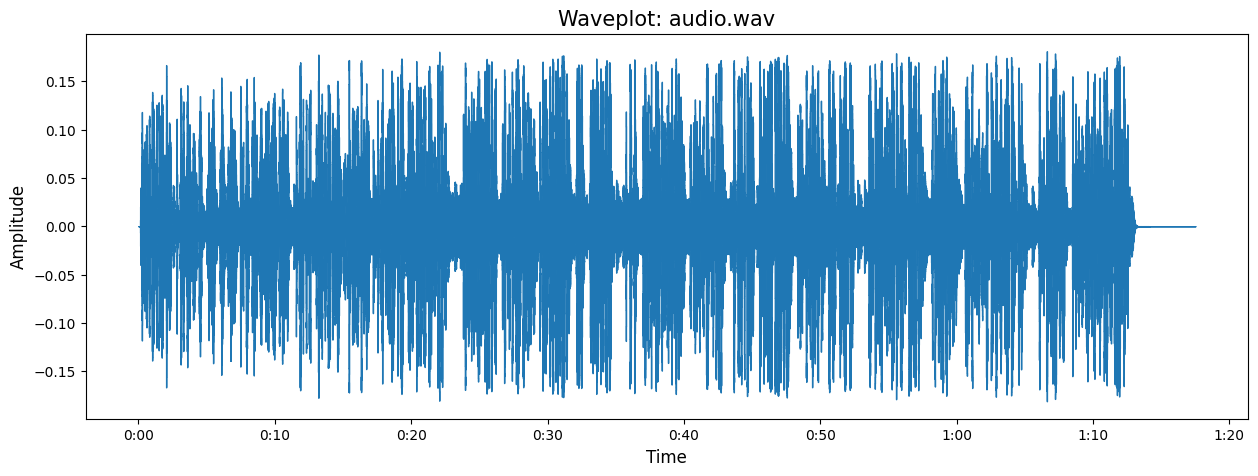

In [16]:
display_amplitude(wavfile)

## Text to speech with Azure Speech

In [17]:
def azure_tts(audio_filepath, locale):
    """
    Azure TTS
    """
    audio_config = speechsdk.audio.AudioConfig(filename=audio_filepath)
    speech_config = speechsdk.SpeechConfig(
        subscription=azure_speech_key, region=azure_service_region
    )
    speech_config.request_word_level_timestamps()
    speech_config.speech_recognition_language = locale
    speech_config.output_format = speechsdk.OutputFormat(1)

    # Creates a recognizer with the given settings
    speech_recognizer = speechsdk.SpeechRecognizer(
        speech_config=speech_config, audio_config=audio_config
    )

    # Variable to monitor status
    done = False

    # Service callback for recognition text
    transcript_display_list = []
    transcript_ITN_list = []
    confidence_list = []
    words = []

    def parse_azure_result(evt):
        import json

        response = json.loads(evt.result.json)
        transcript_display_list.append(response["DisplayText"])
        confidence_list_temp = [item.get("Confidence") for item in response["NBest"]]
        max_confidence_index = confidence_list_temp.index(max(confidence_list_temp))
        confidence_list.append(response["NBest"][max_confidence_index]["Confidence"])
        transcript_ITN_list.append(response["NBest"][max_confidence_index]["ITN"])
        words.extend(response["NBest"][max_confidence_index]["Words"])

    # Service callback that stops continuous recognition upon receiving an event `evt`
    def stop_cb(evt):
        print("CLOSING on {}".format(evt))
        speech_recognizer.stop_continuous_recognition()
        nonlocal done
        done = True

        # Do something with the combined responses
        print(transcript_display_list)
        print(confidence_list)
        print(words)

    # Connect callbacks to the events fired by the speech recognizer
    speech_recognizer.recognizing.connect(
        lambda evt: logger.debug("RECOGNIZING: {}".format(evt))
    )
    speech_recognizer.recognized.connect(parse_azure_result)
    speech_recognizer.session_started.connect(
        lambda evt: logger.debug("SESSION STARTED: {}".format(evt))
    )
    speech_recognizer.session_stopped.connect(
        lambda evt: logger.debug("SESSION STOPPED {}".format(evt))
    )
    speech_recognizer.canceled.connect(
        lambda evt: logger.debug("CANCELED {}".format(evt))
    )
    # stop continuous recognition on either session stopped or canceled events
    speech_recognizer.session_stopped.connect(stop_cb)
    speech_recognizer.canceled.connect(stop_cb)

    # Start continuous speech recognition
    speech_recognizer.start_continuous_recognition()
    while not done:
        time.sleep(0.5)

    return transcript_display_list, confidence_list, words

In [18]:
transcript, confidence, words = azure_tts(wavfile, "en-US")

CLOSING on SpeechRecognitionCanceledEventArgs(session_id=307556cce5914ded9a7e3fff38b608fe, result=SpeechRecognitionResult(result_id=286a401063964626aa032f131774114e, text="", reason=ResultReason.Canceled))
['Introducing Azure AI Studio, a full lifecycle tool to build, customize, train, evaluate and deploy the latest next generation models responsibly with just a few clicks. Developers can ground AI models with their structured and unstructured data to quickly and easily build customized, cutting edge conversational experiences for their customers. Developers can take advantage of a new model catalog that works with the popular models organizations use, including those.', 'From Azure Open AI Service, Hugging Face and many other open source models with Prompt Flow, developers can combine relevant data from your organization and create a detailed prompt to get better results. Prompt Flow works with Foundation internally developed or open source models and uses popular open source tools La

In [19]:
video_transcript = " ".join(transcript)
len(video_transcript)

1112

In [20]:
print(video_transcript)

Introducing Azure AI Studio, a full lifecycle tool to build, customize, train, evaluate and deploy the latest next generation models responsibly with just a few clicks. Developers can ground AI models with their structured and unstructured data to quickly and easily build customized, cutting edge conversational experiences for their customers. Developers can take advantage of a new model catalog that works with the popular models organizations use, including those. From Azure Open AI Service, Hugging Face and many other open source models with Prompt Flow, developers can combine relevant data from your organization and create a detailed prompt to get better results. Prompt Flow works with Foundation internally developed or open source models and uses popular open source tools Lang Chain and Semantic Kernel. And because the AI systems we build are designed to support our AI principles with Azure AI content safety. We are making it easier for you to test and evaluate your AI deployments 

In [21]:
words

[{'Word': 'introducing',
  'Offset': 2000000,
  'Duration': 8100000,
  'Confidence': 0.7578639},
 {'Word': 'azure',
  'Offset': 10200000,
  'Duration': 5100000,
  'Confidence': 0.69740736},
 {'Word': 'AI',
  'Offset': 15400000,
  'Duration': 3700000,
  'Confidence': 0.5534592},
 {'Word': 'studio',
  'Offset': 19200000,
  'Duration': 8500000,
  'Confidence': 0.96035683},
 {'Word': 'a',
  'Offset': 28200000,
  'Duration': 1300000,
  'Confidence': 0.5521275},
 {'Word': 'full',
  'Offset': 29600000,
  'Duration': 3500000,
  'Confidence': 0.9258533},
 {'Word': 'lifecycle',
  'Offset': 33200000,
  'Duration': 6000000,
  'Confidence': 0.8452919},
 {'Word': 'tool',
  'Offset': 39300000,
  'Duration': 3400000,
  'Confidence': 0.92282414},
 {'Word': 'to',
  'Offset': 42800000,
  'Duration': 1300000,
  'Confidence': 0.9029979},
 {'Word': 'build',
  'Offset': 44200000,
  'Duration': 5700000,
  'Confidence': 0.9780737},
 {'Word': 'customized',
  'Offset': 50600000,
  'Duration': 8200000,
  'Confide

## Azure Open AI analysis

In [22]:
def azure_openai(prompt, temperature=0.7):
    """
    Get Azure Open AI results
    """
    preprompt = (
        "You are going to give answer based on the transcript of a video file.\n"
    )
    prompt = preprompt + prompt

    results = openai.Completion.create(
        engine=model,
        prompt=prompt,
        temperature=temperature,
        max_tokens=400,
    )

    answer = results["choices"][0]["text"].strip("\n")

    return answer

In [23]:
prompt = f"""What is the language of the following transcript.
Text: {video_transcript}
"""

print(azure_openai(prompt))

English


In [24]:
prompt = f"""Create a summary of the following transcript.
Text: {video_transcript}
    
Add a title to the summary.
 Your summary should be informative and factual, covering the most important aspects of the topic.
 Start your summary with an INTRODUCTION PARAGRAPH that gives an overview of the topic FOLLOWED
by BULLET POINTS if possible AND end the summary with a CONCLUSION PHRASE.
"""

print(azure_openai(prompt))

Title: Introducing Azure AI Studio: The Trusted Tool for Building Next Generation AI Applications

Introduction: Microsoft Azure AI Studio is a comprehensive tool designed to help developers quickly and easily build customized, cutting-edge conversational experiences for their customers. It provides a lifecycle for creating, customizing, training, evaluating and deploying models using AI principles and content safety. 

Bullet Points: 
• Azure AI Studio offers a model catalog for popular models such as those from Azure Open AI Service, Hugging Face and other open source models. 
• Prompt Flow is a feature that combines relevant data from an organization to create a detailed prompt to get better results.
• It uses Lang Chain and Semantic Kernel, two popular open source tools for testing and evaluating AI deployments to ensure content safety.

Conclusion: Azure AI Studio is the trusted solution for developers to build next generation AI applications with ease and safety.


In [25]:
prompt = f"""Generate some keywords to classify this transcript.
Text: {video_transcript}
"""

print(azure_openai(prompt))

Keywords: Azure AI Studio, AI models, structured data, unstructured data, model catalog, Azure Open AI Service, Hugging Face, Prompt Flow, Foundation, Lang Chain, Semantic Kernel, AI content safety, AI principles, AI applications.


In [26]:
prompt = f"""Write a summary of this transcript with some emojis.
Text: {video_transcript}
"""

print(azure_openai(prompt))

Azure AI Studio offers a full lifecycle of tools for developers to build, customize, train, evaluate, and deploy cutting-edge models for conversational experiences. With access to a model catalog that includes Azure Open AI Service, Hugging Face, and other open source models, developers can quickly craft personalized experiences with data from their organization. Internal models and open source tools such as Lang Chain and Semantic Kernel are also supported. Additionally, Azure AI Studio offers content safety measures for AI systems, making it easy to test and evaluate for safety. 🤖📊🔍💻


In [27]:
prompt = f"""Write a tweeter post about this transcript.
Text: {video_transcript}
"""

print(azure_openai(prompt))

Check out Azure AI Studio! A full lifecycle tool to easily and responsibly build, customize, train, evaluate, and deploy the latest cutting-edge #AI models with a few clicks. Create detailed prompts with Foundation models, Lang Chain, and Semantic Kernel and ensure safety with Azure AI content safety. #Azure #NextGenAI


In [28]:
prompt = f"""What are the products mentionned?.
Text: {video_transcript}
"""

print(azure_openai(prompt))

Products mentioned: 
Azure AI Studio, Azure Open AI Service, Hugging Face, Prompt Flow, Lang Chain, Semantic Kernel, Azure AI Content Safety.


In [29]:
prompt = f"""Classify this into one of these categories: SPORTS, AI, POLITICS, ART, MUSIC?.
Text: {video_transcript}
"""

print(azure_openai(prompt))

AI


In [30]:
prompt = f"""Classify this into one of these categories: SPORTS, AI, POLITICS, ART, MUSIC? Explain why.
Text: {video_transcript}
"""

print(azure_openai(prompt))

AI. This text is describing the features of Azure AI Studio, which is a tool used to build and deploy AI models.


In [31]:
prompt = f"""Do we have some mentions about Microsoft technologies?
Text: {video_transcript}
"""

print(azure_openai(prompt))

Yes, there are mentions about Microsoft technologies in the transcript. Specifically, the transcript mentions Azure AI Studio, Azure Open AI Service, Prompt Flow, Foundation, Lang Chain, Semantic Kernel, and Azure AI Content Safety.


In [32]:
prompt = f"""Can you explain what is Azure AI Studio?
Text: {video_transcript}
"""

print(azure_openai(prompt))

Azure AI Studio is a full lifecycle tool for developers to build, customize, train, evaluate and deploy the latest next-generation models responsibly with just a few clicks. It provides a model catalog that works with popular models from Azure Open AI Service, Hugging Face, and other open source models. It features Prompt Flow, which can combine relevant data from the organization to create a detailed prompt for better results, and uses popular open source tools such as Lang Chain and Semantic Kernel to do so. It is designed to support AI principles with Azure AI content safety, and to make it easier for developers to test and evaluate AI deployments for safety.
